In [1]:
# imports from custom library
import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ortho_group  # Requires version 0.18 of scipy

import matplotlib.pyplot as plt
from matplotlib import gridspec

# This is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

# PCA code blocks

In [96]:
def center(X):
    '''
    A function for normalizing each feaure dimension of an input array, mean-centering
    
    '''
    X_means = np.mean(X,axis=1)[:,np.newaxis]
    X_normalized = X - X_means

    return X_normalized

def compute_pcs(X,lam):
    '''
    A function for computing the principal components of an input data matrix.  Both
    principal components and variance parameters (eigenvectors and eigenvalues of XX^T)
    are returned
    '''
    # create the correlation matrix
    P = float(X.shape[1])
    Cov = 1/P*np.dot(X,X.T) + lam*np.eye(X.shape[0])

    # use numpy function to compute eigenvalues / vectors of correlation matrix
    D,V = np.linalg.eigh(Cov)
    return D,V

def pca_transform_data(X,**kwargs):
    '''
    A function for producing the full PCA transformation on an input dataset X.  
    '''
    # user-determined number of principal components to keep, and regularizer penalty param
    num_components = X.shape[0]
    if 'num_components' in kwargs:
        num_components = kwargs['num_components']
    lam = 10**(-7)
    if 'lam' in kwargs:
        lam = kwargs['lam']
    
    # compute principal components
    D,V = compute_pcs(X,lam)
    V = np.fliplr(V[:,-num_components:])
    D = np.fliplr(D[-num_components:][np.newaxis,:])

    # compute transformed data for PC space: V^T X
    W = np.dot(V.T,X)
    return W,V

In [97]:
x_pca,pcs = pca_transform_data(x_center,num_components=2)


# Static plotters

In [52]:
# import standard plotting and animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import gridspec
from IPython.display import clear_output
from matplotlib.text import Annotation
import time


def static_plotter(x,y):
    # define all colors
    colors = ['cornflowerblue','salmon','lime','bisque','mediumaquamarine','b','m','g']

    ### generate base figure ###
    fig = plt.figure(figsize=(9,5))

    # create subplot with 2 panels
    gs = gridspec.GridSpec(1, 3, width_ratios=[1,10,1]) 
    ax1 = plt.subplot(gs[0]); ax1.axis('off') 
    ax = plt.subplot(gs[1]); ax.axis('off') 
    ax3 = plt.subplot(gs[2]); ax3.axis('off')

    ### scatter points ###
    # scatter points in both panels
    y=y.astype(int)
    class_nums = np.unique(y)
    C = len(class_nums)
    for c in range(C):
        ind = np.argwhere(y == class_nums[c])
        ind = [v[1] for v in ind]
        ax.scatter(x[0,ind],x[1,ind],s = 80,color = colors[c],edgecolor = 'k',linewidth = 1.5)
    plt.show()

# Import and display data

In [144]:
data = np.loadtxt('test_data.csv',delimiter=',')
x = data[:2,:]
y = data[-1:,:]

In [189]:
# mean-center input
x_center = center(x)

# pca transform centered data
x_pca,pcs = pca_transform_data(x_center,num_components=2)

# project onto first pc
first_pc = pcs[:,0:1]
new_pcs = np.hstack((first_pc,np.zeros((2,1))))

# rotate projection back into 2-d based on both original pcs
x_test = np.dot(pcs,np.dot(new_pcs.T,x_center))

# Animate transitions

In [240]:
# import standard plotting and animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import gridspec
from IPython.display import clear_output
from matplotlib.text import Annotation
import time

class Animator:
    def __init__(self):
        self.colors = ['cornflowerblue','salmon','lime','bisque','mediumaquamarine','b','m','g']
        
        
    def init_figure(self):
#         ### generate base figure ###
#         fig = plt.figure(figsize=(15,5))

#         # create subplot with 2 panels
#         gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,1]) 
#         ax1 = plt.subplot(gs[0]); ax1.axis('off') 
#         ax = plt.subplot(gs[1]); ax.axis('off')
#         ax3 = plt.subplot(gs[2]); ax3.axis('off')
        
        
        ### generate base figure ###
        fig = plt.figure(figsize=(8,8))

        # create subplot with 2 panels
        gs = gridspec.GridSpec(1, 1) 
        ax = plt.subplot(gs[0]); ax.axis('off')
        
        return fig,ax
        
    def static_plotter(self,ax,x,y):
        ### scatter points ###
        # scatter points in both panels
        y=y.astype(int)
        class_nums = np.unique(y)
        C = len(class_nums)
        for c in range(C):
            ind = np.argwhere(y == class_nums[c])
            ind = [v[1] for v in ind]
            ax.scatter(x[0,ind],x[1,ind],s = 140,color = self.colors[c],edgecolor = 'k',linewidth = 1.5,zorder=2)
            
    def add_linear_guidelines(self,ax,x3,x2):
        # loop over points and add visual guidelines
        for p in range(x2.shape[1]):
            x3_p = x3[:,p]
            x2_p = x2[:,p]
            ax.plot([x3_p[0],x2_p[0]],[x3_p[1],x2_p[1]],c='k',linestyle='--',alpha=0.9,zorder=0)
        
    def add_pc_plane(self,ax,t1,t2):
        ax.plot(t1,t2,c='k',zorder=0)
    
    def animate_transition(self,savepath,x1,x2,y,pc,**kwargs):
        # set number of frames to video
        orig_num = 5
        if 'orig_num' in kwargs:
            orig_num = kwargs['orig_num']     
        pc_num = 5
        if 'pc_num' in kwargs:
            pc_num = kwargs['pc_num']    
        pause_num = 5
        if 'pause_num' in kwargs:
            pause_num = kwargs['pause_num']           
        trans_num = 5
        if 'trans_num' in kwargs:
            trans_num = kwargs['trans_num']            
            
            
        # compute lambda transition points
        lams = list(np.linspace(1,0,trans_num))
        
        # compute pc plane
        s = np.linspace(-2,2,pc_num)
        pcn = pc/(pc[0]**2 + pc[1]**2)**(0.5)
        t1 = pcn[0]*s
        t2 = pcn[1]*s
            
        # initiate figure
        fig,ax = self.init_figure()
        artist = fig
        
        # animate
        num_frames = orig_num + pc_num + pause_num + trans_num
        print ('starting animation rendering...')
        def animate(t):
            ax.cla()
            ax.axis('off')
            
            # print rendering update            
            if np.mod(t+1,25) == 0:
                print ('rendering animation frame ' + str(t+1) + ' of ' + str(num_frames))
            if t == num_frames - 1:
                print ('animation rendering complete!')
                time.sleep(1.5)
                clear_output()
                
            # show original dataset for several frames
            print(t)
            if t < orig_num + pc_num + pause_num:
                # plot orig data
                self.static_plotter(ax,x1,y)
                
                # transition pc plane into frame
                if t > orig_num and t < orig_num + pc_num+1:
                    self.add_pc_plane(ax,t1[:t-orig_num],t2[:t-orig_num])
                if t > orig_num + pc_num:
                    self.add_pc_plane(ax,t1,t2)
            else:
                # create current transition
                lam = lams[0]; lams.pop(0)
                x3 = lam*x1 + (1-lam)*x2
                self.static_plotter(ax,x3,y)
                self.add_linear_guidelines(ax,x3,x2)
                self.add_pc_plane(ax,t1,t2)

            # fix viewing limits
            ax.set_xlim([-2,2])
            ax.set_ylim([-2,2])
            return artist,

        anim = animation.FuncAnimation(fig, animate ,frames=num_frames, interval=num_frames, blit=True)

        # produce animation and save
        fps = 50
        if 'fps' in kwargs:
            fps = kwargs['fps']
        anim.save(savepath, fps=fps, extra_args=['-vcodec', 'libx264'])
        
        clear_output()          

/Users/Nurgetson/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


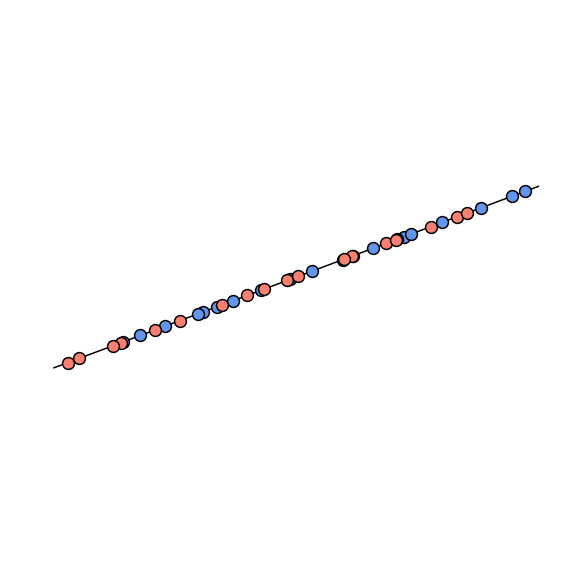

In [243]:
demo = Animator()
savepath = 'test_animation.mp4'
demo.animate_transition(savepath,x_center,x_test,y,first_pc,fps=10,orig_num=5,pc_num=15,pause_num = 15,trans_num=15)

# Random projection

In [244]:
random_proj = np.random.randn(2,1)
random_proj /= (random_proj[0]**2 + random_proj[1]**2)**(0.5)
rand_pcs = np.hstack((random_proj,np.zeros((2,1))))


In [254]:
x_test_2 = np.dot(rand_pcs,np.dot(rand_pcs.T,x_center))

/Users/Nurgetson/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


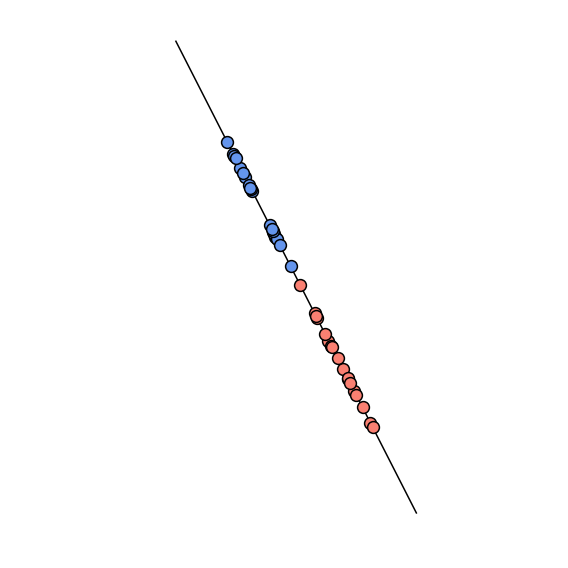

In [255]:
demo = Animator()
savepath = 'test_animation_2.mp4'
demo.animate_transition(savepath,x_center,x_test_2,y,random_proj,fps=10,orig_num=5,pc_num=15,pause_num = 15,trans_num=15)